# DateTime
This class is used to obtain a Datetime formatted Pandas Dataframe of a given Item.

## Test

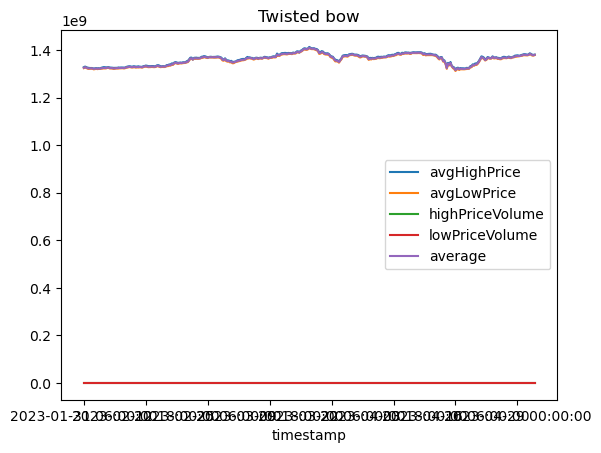

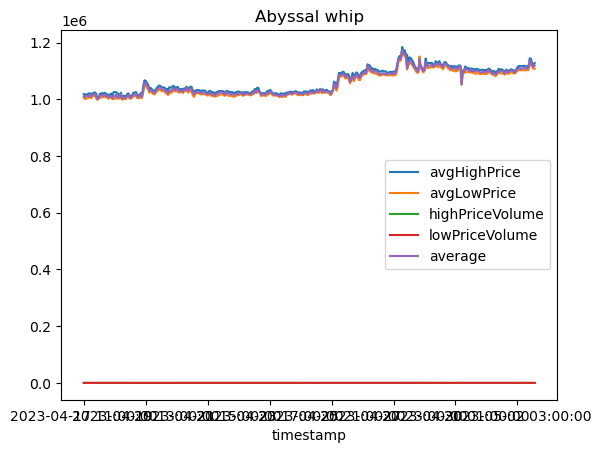

In [1]:
from Modules import DateTimeHelper

name1 = "Twisted bow"
data1 = DateTimeHelper.getDT(name1 , "6h")

name2 = "Abyssal whip"
data2 = DateTimeHelper.getDT(name2 , "1h")

# Creating a plot
res1 = data1.plot(title=name1).get_figure()
res2 = data2.plot(title=name2).get_figure()


## How does DateTimeHelper work?

##### Import everything needed
```py
import numpy as np
import NameIDHelper
from urllib.request import urlopen, Request
import json
from datetime import datetime
import pandas as pd
```

##### This function is used to replace all nan values while also adding an average col. This can be altered in the future to determine other ways of calculating averages
there are many times for smaller items that dont have enough trade volume that have null for some of the values   
if this is the case i want to set the value equal to the other val:
* highval = null, set highval = lowval
* lowval = null, set lowval = highval
* if both are null... remove row

```py
def addAverage(dt):
    # the volumes will still be there to calculate an average
    average = []
    for time in dt.values:
        averageVal = (time[3]*time[1] + time[2]*time[0]) / (time[3] + time[2])
        if (np.isnan(averageVal)):
            if time[0] == time[1]:
                # uh oh
                continue
            elif np.isnan(time[0]):
                averageVal = time[1]
            elif np.isnan(time[1]):
                averageVal = time[0]
        average.append(averageVal)
    dt['average'] = average
    return dt
```
##### This is a function that gets the DateTime formatted DataFrame
```py
def getDT(name,timestep):
    url = 'https://prices.runescape.wiki/api/v1/osrs'
    # we want the latest data, so lets add that to the url
    url += "/timeseries?timestep="
    url += timestep
    url += "&id="
    # lets add the abyssal whip to the url:
    url += str(NameIDHelper.NameToID(name))

    headers = {
        # the wiki blocks all common user-agents in order to prevent spam
        # after talking with some of the API maintainers over discord they asked me to include my discord in the user-agent
        'User-Agent': 'DateTimeHelper - @Be#9998',
    }
    req = Request(url, headers=headers)
    with urlopen(req) as response:
                latestData = response.read()
    data = json.loads(latestData)

    for date in data['data']:
        date['timestamp'] = datetime.utcfromtimestamp(date['timestamp']).strftime('%Y-%m-%d %H:%M:%S')
    data = data['data']
    
    dt_pandas = pd.DataFrame(data)
    dt_pandas = dt_pandas.set_index('timestamp')
    dt_pandas = addAverage(dt_pandas)
    dt_pandas.drop(columns=['lowPriceVolume', 'highPriceVolume'], inplace=True)
    return dt_pandas
```

In [2]:
import json
from datetime import datetime
from urllib.request import Request, urlopen

import numpy as np
import pandas as pd

from Modules import NameIDHelper

def addAverage(dt: pd.DataFrame) -> pd.DataFrame:
    """Adds a col "average" to the Pandas Dataframe passed in

    Args:
        dt (Dataframe): The Dataframe to be modified

    Returns:
        Dataframe: The modified Dataframe
    """
    # the volumes will still be there to calculate an average
    average = []
    for time in dt.values:
        # averageVal = (time['lowPriceVolume']*time['avgLowPrice'] + time['highPriceVolume']*time['avgHighPrice']) / (time['lowPriceVolume'] + time['highPriceVolume'])
        averageVal = (time[3]*time[1] + time[2]*time[0]) / (time[3] + time[2])
        if (np.isnan(averageVal)):
            if time[0] == time[1]:
                # uh oh
                continue
            elif np.isnan(time[0]):
                averageVal = time[1]
            elif np.isnan(time[1]):
                averageVal = time[0]
        average.append(averageVal)
    dt['average'] = average
    return dt

def getDT(name: str, timestep: str) -> pd.DataFrame:
    """Returns a Datetime formated Pandas Dataframe of an item

    Args:
        name (str): The name of the item
        timestep (str): The timestep (e.g. "5m", "1h", "6h")

    Returns:
        pd.DataFrame: A Datetime formated Pandas Dataframe of an item
    """
    url = 'https://prices.runescape.wiki/api/v1/osrs'
    # we want the latest data, so lets add that to the url
    url += "/timeseries?timestep="
    url += timestep
    url += "&id="
    # lets add the abyssal whip to the url:
    url += str(NameIDHelper.NameToID(name))

    headers = {
        # the wiki blocks all common user-agents in order to prevent spam
        # after talking with some of the API maintainers over discord they asked me to include my discord in the user-agent
        'User-Agent': 'DateTimeHelper - @Be#9998',
    }
    req = Request(url, headers=headers)
    with urlopen(req) as response:
        latestData = response.read()
    data = json.loads(latestData)

    for date in data['data']:
        date['timestamp'] = datetime.utcfromtimestamp(
            date['timestamp']).strftime('%Y-%m-%d %H:%M:%S')
    data = data['data']

    dt_pandas = pd.DataFrame(data)
    dt_pandas = dt_pandas.set_index('timestamp')
    # dt_pandas.dropna(inplace=True)
    dt_pandas = addAverage(dt_pandas)
    print(dt_pandas)
    dt_pandas.drop(columns=['lowPriceVolume', 'highPriceVolume'], inplace=True)
    return dt_pandas

dt = getDT("Twisted bow", "6h")

                     avgHighPrice  avgLowPrice  highPriceVolume  \
timestamp                                                         
2023-01-31 06:00:00  1.328201e+09   1324313694               11   
2023-01-31 12:00:00  1.330920e+09   1326278056               32   
2023-01-31 18:00:00  1.328519e+09   1325200298               57   
2023-02-01 00:00:00  1.326382e+09   1322229854               70   
2023-02-01 06:00:00  1.325635e+09   1320850466               30   
...                           ...          ...              ...   
2023-05-01 12:00:00  1.386715e+09   1381897685               57   
2023-05-01 18:00:00  1.384244e+09   1380788059               63   
2023-05-02 00:00:00  1.380776e+09   1377144859               60   
2023-05-02 06:00:00  1.380001e+09   1376990197               24   
2023-05-02 12:00:00  1.381319e+09   1379293499               44   

                     lowPriceVolume       average  
timestamp                                          
2023-01-31 06:00:00     